In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from datetime import date
sns.set()
%matplotlib inline

In [2]:
sns.set_style("whitegrid")

In [3]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing

In [4]:
import pwlf

In [5]:
plt.rcParams['figure.figsize'] = [16, 9]

In [6]:
w = pd.read_csv(r'The revised 292 F - 2018-12-31.csv',parse_dates=['Timestamp'], index_col='Timestamp')

In [7]:
w = (w - 32)/1.8
w = w.round(2)

In [8]:
e = pd.read_csv(r'afterQ295(Dec2).csv',parse_dates=['Timestamp'], index_col='Timestamp')

In [9]:
building_list = pd.read_excel('Revised startup and shutdown time all categories.xlsx', sheet_name='Office')
building_4A = building_list[building_list['Climate Zone'] == '4A']
buildings = building_4A['Building ID']

In [10]:
buildings = np.unique(buildings)

In [11]:
len(buildings)

37

In [12]:
buildings = buildings[buildings != 'MD0325ZZ']

In [13]:
building_info = pd.read_excel('extracted data of 295 buildings.xlsx',  index_col=0)

In [14]:
building_info['code']

0      AK0001ZZ
1      AK0013ZZ
2      AK0031AA
3      AL0003AC
4      AL0011ZZ
         ...   
290    IL0303ZZ
291    IL0311ZZ
292    IL2125ZZ
293    IN0031ZZ
294    KY0013ZZ
Name: code, Length: 295, dtype: object

## MD0205ZZ & MO0106ZZ, MO0134zz are deleted due to the electricity heating

In [15]:
segment = {'DC0010ZZ': 2,
           'DC0011ZZ': 2,
           'DC0021ZZ': 2,
           'DC0078ZZ': 2,
           'DC0313ZZ': 2,
           'DC0459AF': 2,
           'DC0463ZZ': 2,
           'DC0501BC': 2,
           'DC0505ZZ': 2,
           'MD0000HC': 2,
           'MD0334ZZ': 2,
           'MD0778AG': 2,
           'MO0000AF': 2,
           'MO0127ZZ': 2,
           'NC0002AE': 2,
           'PA0000AT': 2,
           'PA0144ZZ': 2,
           'VA0088ZZ': 2,
           'WV0054FP': 2,
           'WV0226ZZ': 2}

## Holiday and Problem days

'''Winter Jan, Feb
(2018, 1, 1), "New Year's Day") (Monday)
(2018, 1, 15), 'Martin Luther King Jr. Day') (Monday)
(2018, 2, 19), "Washington's Birthday") (Monday)
Spring Mar, Apr, May
(2018, 5, 28), 'Memorial Day') (Monday)
Summer Jun, Jul, Aug
(2018, 7, 4), 'Independence Day') (Wednesday)
Autumn Sep Oct Nov
(2018, 11, 12), 'Veterans Day (Observed)') (Monday)
(2018, 11, 22), 'Thanksgiving') (Thursday)'''

In [16]:
holidays = [
    date(2018, 1, 1),
    date(2018, 1, 15),
    date(2018, 2, 19),
    date(2018, 5, 28),
    date(2018, 7, 4),
    date(2018, 11, 12),
    date(2018, 11, 22),
    date(2018, 9, 3),
    date(2018, 10, 8),
    date(2018, 12, 5)
]

In [16]:
df_occ = pd.read_csv('4A 19 occupied lean detail.csv')

In [25]:
df_occ['balancePoint'].median()

12.981218786846142

In [49]:
df_occ[df_occ['balancePoint'] < df_occ['balancePoint'].median()].building

1     DC0011ZZ
2     DC0021ZZ
3     DC0078ZZ
9     MD0000HC
12    MO0000AF
13    MO0127ZZ
14    NC0002AE
15    PA0000AT
16    PA0144ZZ
18    WV0054FP
Name: building, dtype: object

Text(0.5, 1.0, 'WV0054FP')

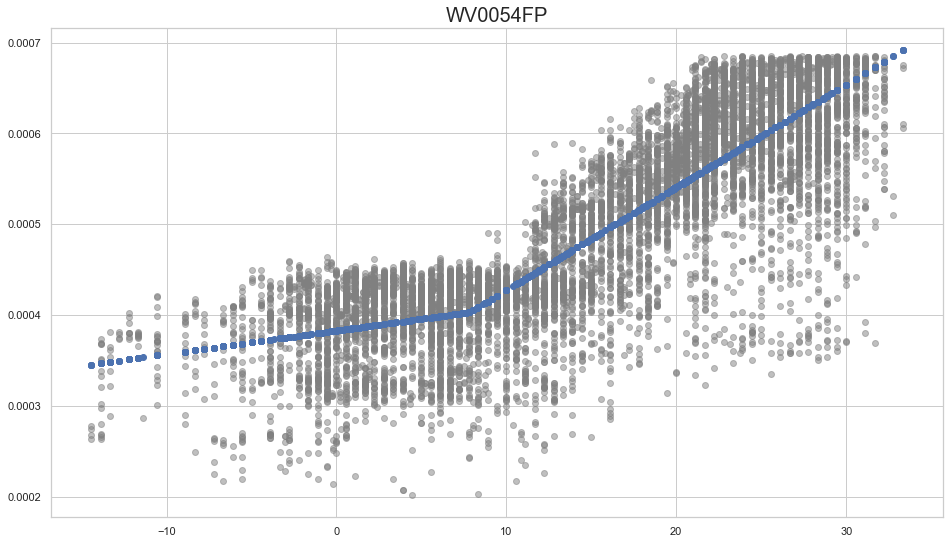

In [148]:
data = pd.DataFrame()
data['w'] = w['WV0054FP']
data['e'] = e['WV0054FP']
data = data.dropna()
data = data[~np.isin(data.index.date, holidays)]
data = data[data.index.weekday < 5].between_time('6:00', '18:00')

clustering = DBSCAN(eps=5, min_samples=8).fit(data)
res = np.unique(clustering.labels_, return_counts=True)
maj = res[0][np.argmax(res[1])]

data['e'] = data['e'] / (building_info['floor area (sf)'][building_info['code'] == 'WV0054FP'].values[0])

x, y = (data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj]
f = pwlf.PiecewiseLinFit(x, y)
res = f.fit(segment['WV0054FP'])
plt.subplots()
plt.scatter((data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj], c='gray', alpha=0.5)
plt.scatter(x, f.predict(x))
plt.title('WV0054FP', fontsize=20)

In [149]:
balance = f.fit_breaks[1]
a1, a2 = f.slopes
b1, b2 = f.intercepts

In [150]:
def fun1(x, balance):
    if x <= balance:
        return a1 * x + b1
    else:
        return a2 * x + b2

In [151]:
def fun2(x, balance ,balance_new):
    delta = balance_new - balance
    if x <= balance_new:
        return a1 * x + b1
    else:
        return a2 * x + b2 + delta * (a1 - a2)

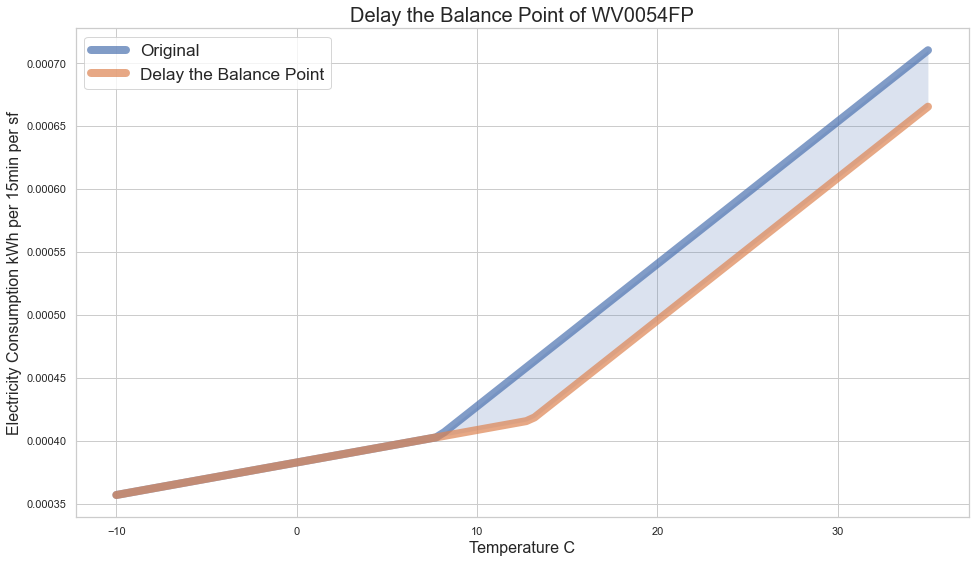

In [152]:
x = np.linspace(-10, 35, 100)
plt.plot(x, [fun1(xi, balance) for xi in x], alpha=0.7, lw=8, label='Original')
plt.plot(x, [fun2(xi, balance, df_occ['balancePoint'].median()) for xi in x], alpha=0.7, lw=8, label='Delay the Balance Point')
plt.fill_between(x, [fun1(xi, balance) for xi in x], [fun2(xi, balance, df_occ['balancePoint'].median()) for xi in x], alpha=0.2)
plt.ylabel('Electricity Consumption kWh per 15min per sf', fontsize=16)
plt.xlabel('Temperature C', fontsize=16)
plt.title('Delay the Balance Point of WV0054FP', fontsize=20)
plt.legend(fontsize='xx-large')

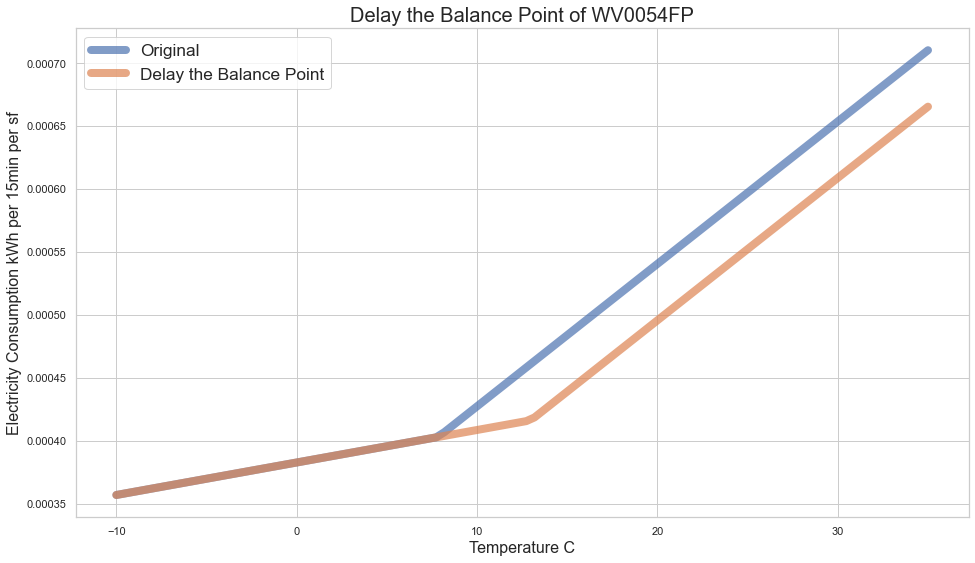

In [153]:
x = np.linspace(-10, 35, 100)
plt.plot(x, [fun1(xi, balance) for xi in x], alpha=0.7, lw=8, label='Original')
plt.plot(x, [fun2(xi, balance, df_occ['balancePoint'].median()) for xi in x], alpha=0.7, lw=8, label='Delay the Balance Point')
# plt.fill_between(x, [fun1(xi, balance) for xi in x], [fun2(xi, balance, df_occ['balancePoint'].median()) for xi in x], alpha=0.2)
plt.ylabel('Electricity Consumption kWh per 15min per sf', fontsize=16)
plt.xlabel('Temperature C', fontsize=16)
plt.title('Delay the Balance Point of WV0054FP', fontsize=20)
plt.legend(fontsize='xx-large')

In [41]:
a = sum([fun2(xi, balance, df_occ['balancePoint'].median()) for xi in (data)['w']])

In [42]:
b = sum([fun1(xi, balance) for xi in (data)['w']])

In [43]:
a_ = a * (building_info['floor area (sf)'][building_info['code'] == 'WV0054FP'].values[0])

In [44]:
b_ = b * (building_info['floor area (sf)'][building_info['code'] == 'WV0054FP'].values[0])

In [45]:
round(100 * ((b_ - a_)/b_), 2)

5.53

In [76]:
def fun1(x, balance, a1, b1, a2, b2):
    if x <= balance:
        return a1 * x + b1
    else:
        return a2 * x + b2

In [77]:
def fun2(x, balance ,balance_new, a1, b1, a2, b2):
    delta = balance_new - balance
    if x <= balance_new:
        return a1 * x + b1
    else:
        return a2 * x + b2 + delta * (a1 - a2)

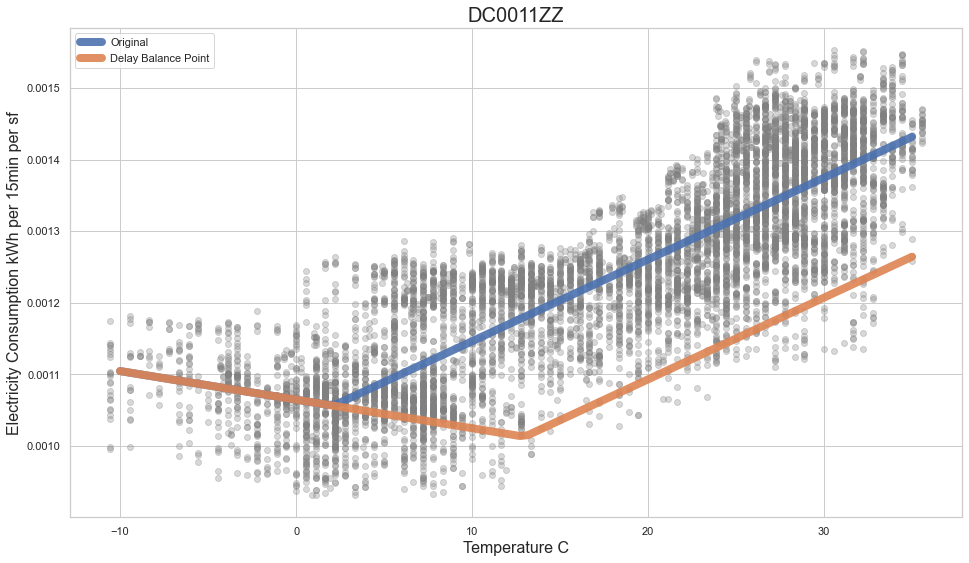

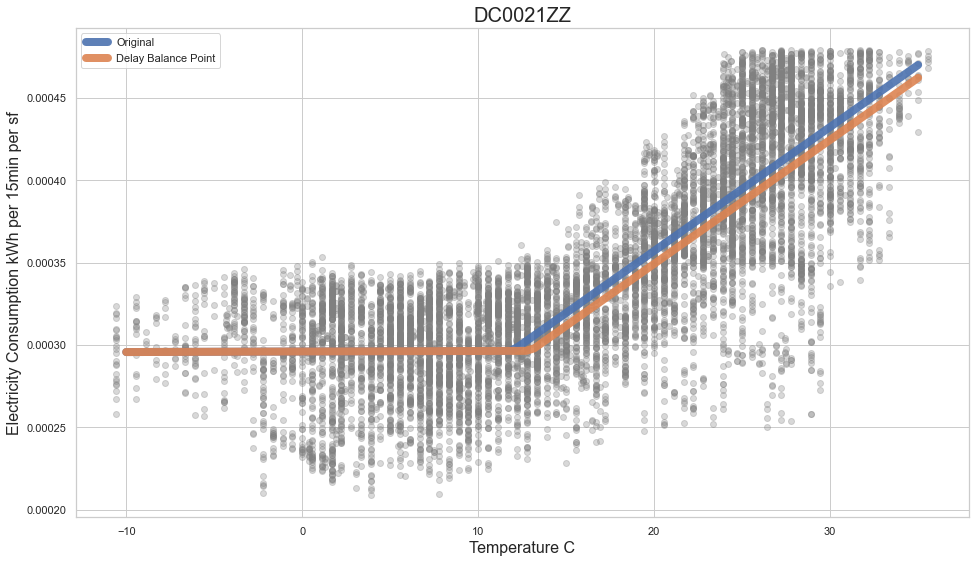

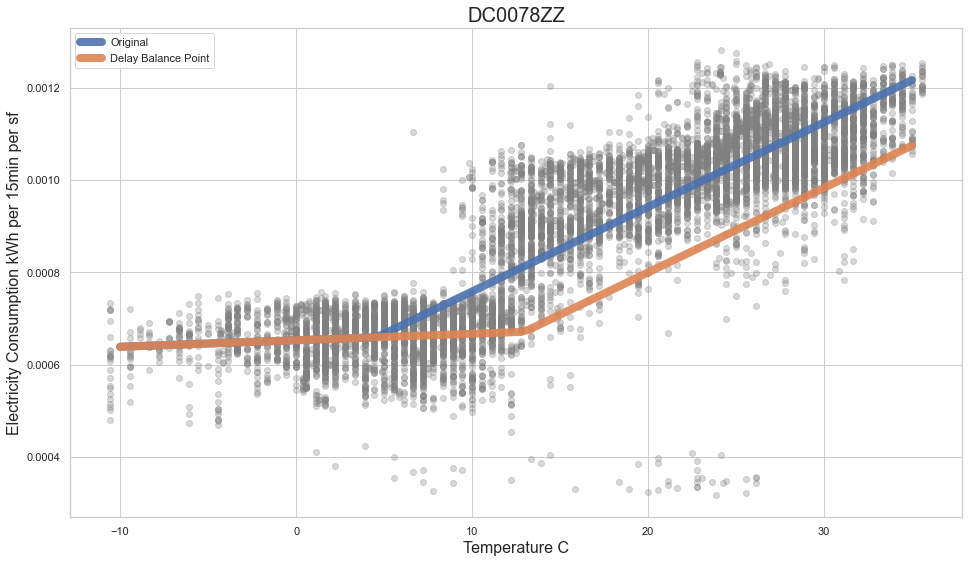

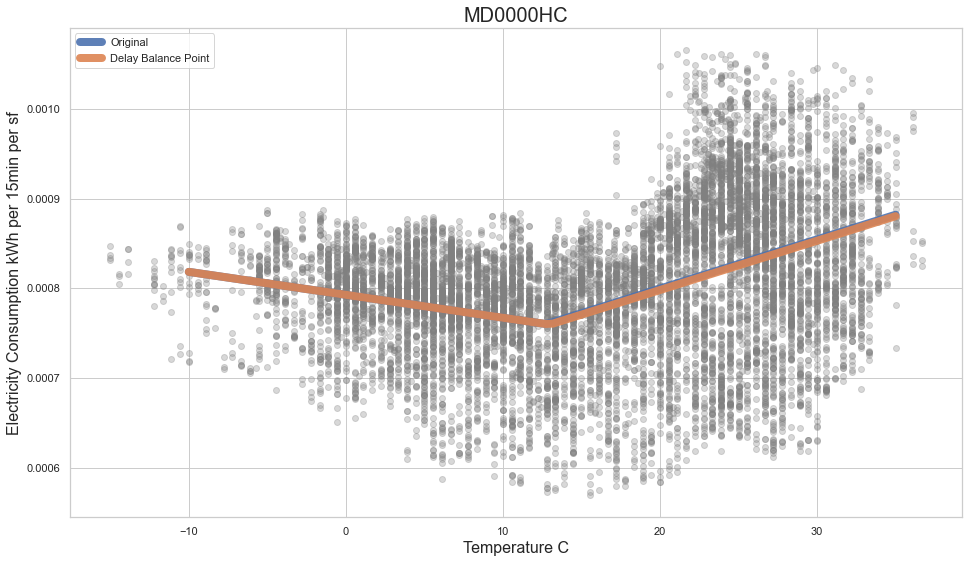

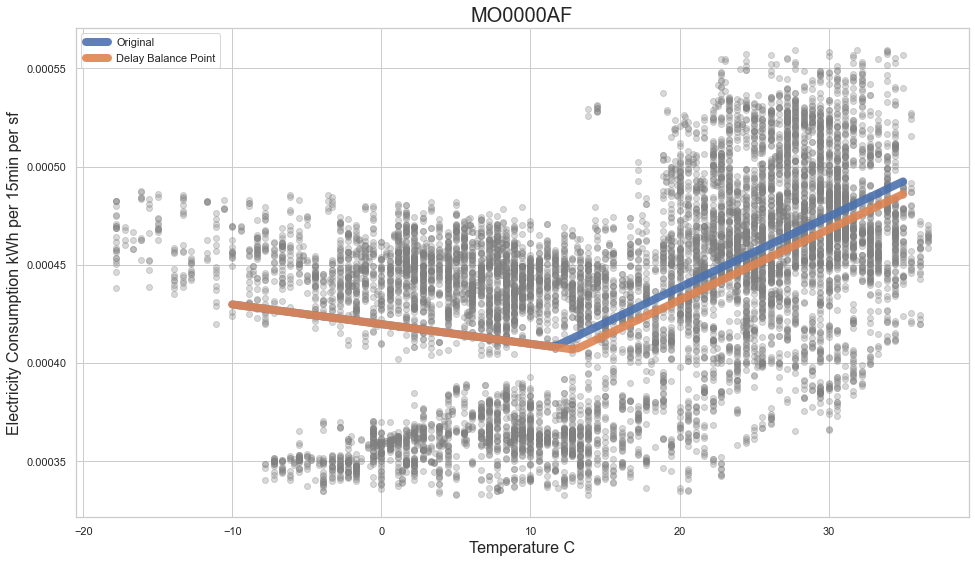

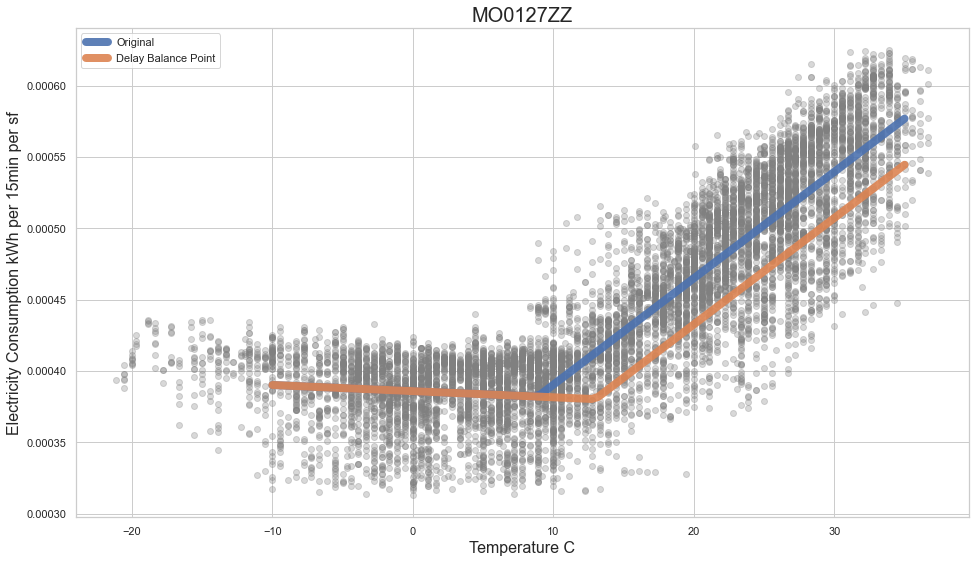

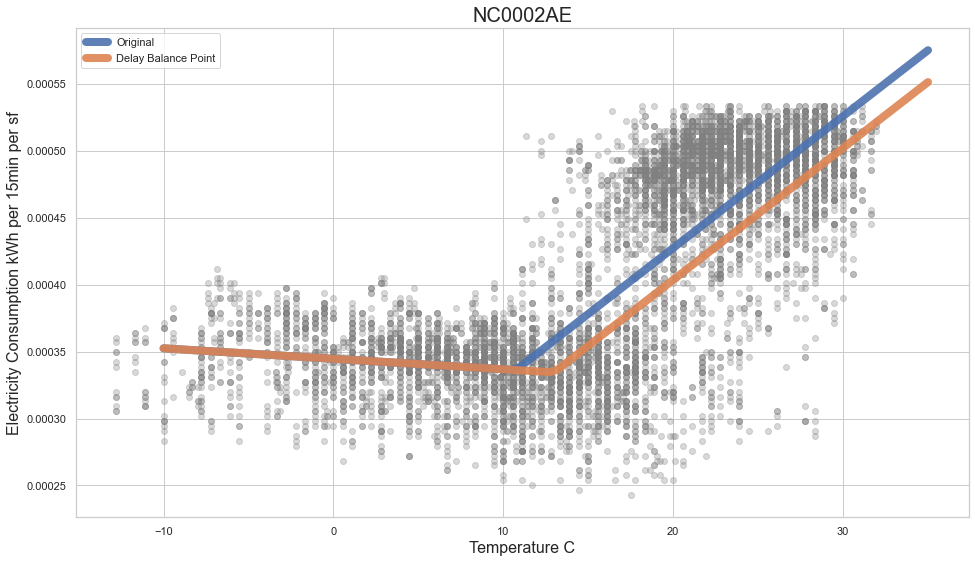

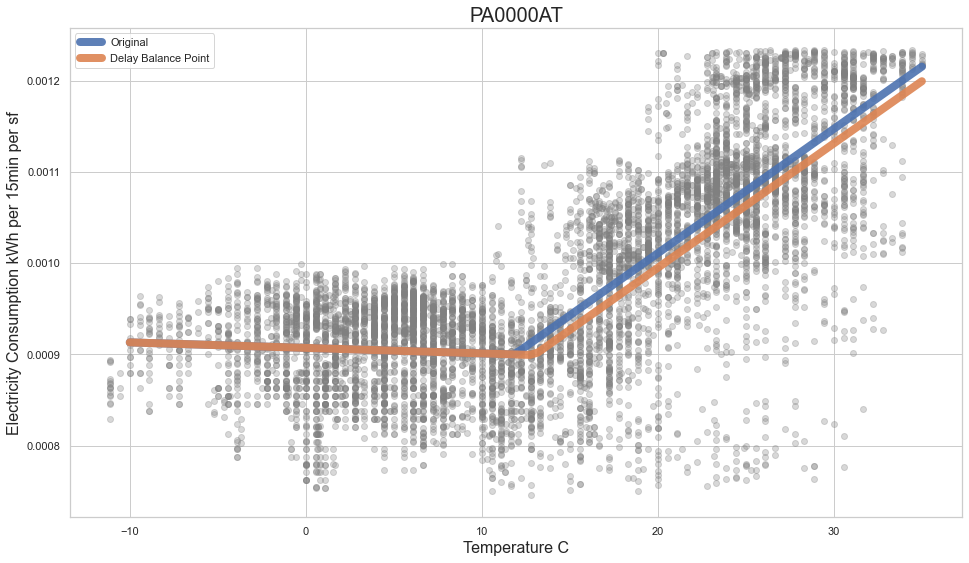

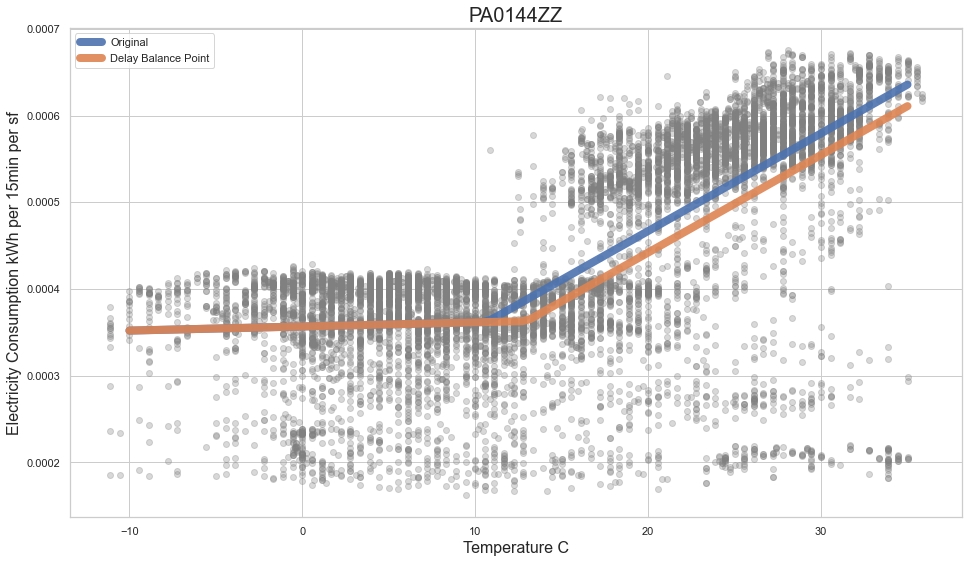

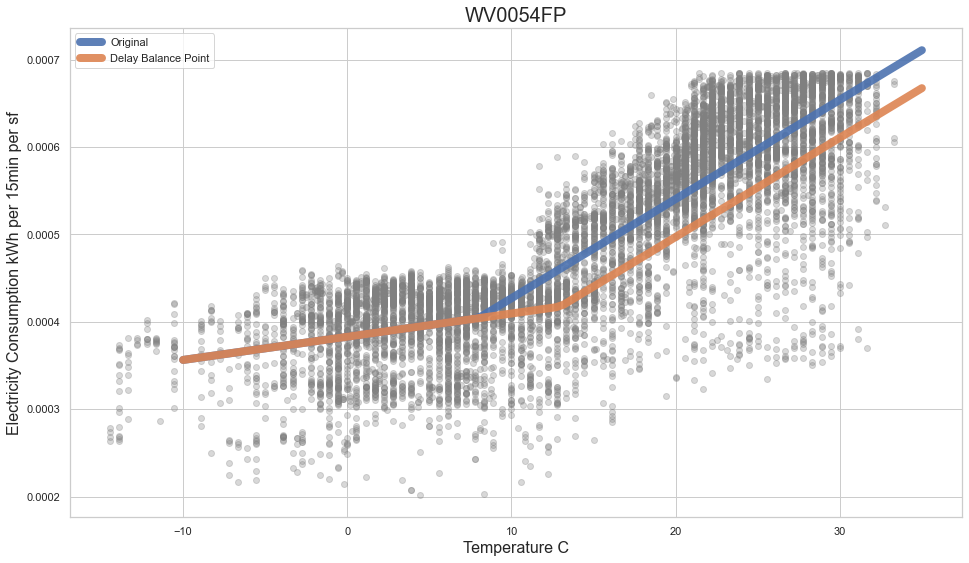

In [78]:
for i in df_occ[df_occ['balancePoint'] < df_occ['balancePoint'].median()].building:
    data = pd.DataFrame()
    data['w'] = w[i]
    data['e'] = e[i]
    data = data.dropna()
    data = data[~np.isin(data.index.date, holidays)]
    data = data[data.index.weekday < 5].between_time('6:00', '18:00')
    
    clustering = DBSCAN(eps=5, min_samples=8).fit(data)
    res = np.unique(clustering.labels_, return_counts=True)
    maj = res[0][np.argmax(res[1])]
    
    data['e'] = data['e'] / (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    
    x, y = (data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj]
    f = pwlf.PiecewiseLinFit(x, y)
    res = f.fit(segment[i])
    plt.subplots()
    plt.scatter((data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj], c='grey', alpha=0.3)
#     plt.scatter((data)['w'][clustering.labels_== maj], f.predict((data)['w'][clustering.labels_== maj]), c='blue', alpha=0.3)
    _, balancePoint, _ = f.fit_breaks
    a1, a2 = f.slopes
    b1, b2 = f.intercepts
#     plt.scatter((data)['w'][clustering.labels_== maj], [fun2(i, balancePoint, df_occ['balancePoint'].median(), a1, b1, a2, b2) for i in (data)['w'][clustering.labels_== maj]], c='red', alpha=0.3)
    plt.title(f'{i}', fontsize=20)
    x = np.linspace(-10, 35, 100)
    plt.plot(x, [fun1(i, balancePoint, a1, b1, a2, b2) for i in x], label='Original',alpha=0.9, lw=8)
    plt.plot(x, [fun2(i, balancePoint, df_occ['balancePoint'].median(), a1, b1, a2, b2) for i in x], label='Delay Balance Point',alpha=0.9, lw=8)
    plt.ylabel('Electricity Consumption kWh per 15min per sf', fontsize=16)
    plt.xlabel('Temperature C', fontsize=16)
    plt.legend()



In [110]:
result = pd.DataFrame()
result['building'] = df_occ[df_occ['balancePoint'] < df_occ['balancePoint'].median()].building
original_e, after_e = [], []

In [111]:
for i in result['building']:
    data = pd.DataFrame()
    data['w'] = w[i]
    data['e'] = e[i]
    data = data.dropna()
    data = data[~np.isin(data.index.date, holidays)]
    data = data[data.index.weekday < 5].between_time('6:00', '18:00')
    
    clustering = DBSCAN(eps=5, min_samples=8).fit(data)
    res = np.unique(clustering.labels_, return_counts=True)
    maj = res[0][np.argmax(res[1])]
    
    data['e'] = data['e'] / (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    
    x, y = (data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj]
    f = pwlf.PiecewiseLinFit(x, y)
    res = f.fit(segment[i])
    
    _, balancePoint, _ = f.fit_breaks
    a1, a2 = f.slopes
    b1, b2 = f.intercepts
    original = sum([fun1(i, balancePoint, a1, b1, a2, b2) for i in (data)['w'][clustering.labels_== maj]])
    original = original * (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    after = sum([fun2(i, balancePoint, df_occ['balancePoint'].median(), a1, b1, a2, b2) for i in (data)['w'][clustering.labels_== maj]])
    after = after * (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    original_e.append(original)
    after_e.append(after)

In [112]:
result['Original'] =  original_e
result['After'] = after_e

In [114]:
result['Potential Energy Saving'] = round(100 * (result['Original'] - result['After'])/result['Original'], 2)

In [115]:
result

,building,Original,After,Potential Energy Saving
1,DC0011ZZ,7107598.827,6.341569e+06,10.78
2,DC0021ZZ,2991346.396,2.948000e+06,1.45
3,DC0078ZZ,531089.343,4.731524e+05,10.91
9,MD0000HC,8203547.201,8.179244e+06,0.30
12,MO0000AF,8106720.092,8.064607e+06,0.52
13,MO0127ZZ,5406511.512,5.189739e+06,4.01
14,NC0002AE,916052.000,8.814773e+05,3.77
15,PA0000AT,3657204.947,3.631775e+06,0.70
16,PA0144ZZ,2748744.015,2.664123e+06,3.08
18,WV0054FP,1145047.854,1.084148e+06,5.32


In [122]:
result['Potential Energy Saving'].mean()

4.084

# 4.08% of Electricity Consumption Saving for Occupied Hour

In [123]:
result.to_csv('Energy Saving after delay balance point for Occupied 4A 19.csv', index=False)

In [116]:
result.iloc[:, :-1]

,building,Original,After
1,DC0011ZZ,7107598.827,6.341569e+06
2,DC0021ZZ,2991346.396,2.948000e+06
3,DC0078ZZ,531089.343,4.731524e+05
9,MD0000HC,8203547.201,8.179244e+06
12,MO0000AF,8106720.092,8.064607e+06
13,MO0127ZZ,5406511.512,5.189739e+06
14,NC0002AE,916052.000,8.814773e+05
15,PA0000AT,3657204.947,3.631775e+06
16,PA0144ZZ,2748744.015,2.664123e+06
18,WV0054FP,1145047.854,1.084148e+06


Text(0.5, 0, '')

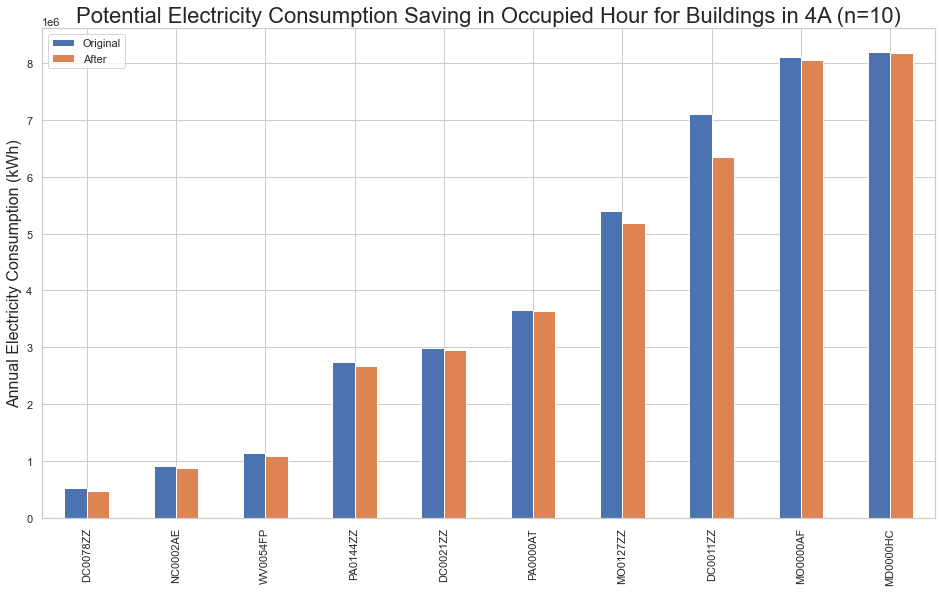

In [154]:
result.sort_values(by=['Original']).iloc[:, :-1].set_index('building').plot(kind="bar")
plt.title('Potential Electricity Consumption Saving in Occupied Hour for Buildings in 4A (n=10)', fontsize=22)
plt.ylabel('Annual Electricity Consumption (kWh)', fontsize=16)
plt.xlabel('')

# Potential Energy Saving for Unoccupied Hours

In [132]:
df_un = pd.read_csv('4A 19 unoccupied lean detail.csv')

In [133]:
df_un[df_un['balancePoint'] < df_un['balancePoint'].median()]

,building,balancePoint,slope1,slope2,intercept1,intercept2
2,DC0021ZZ,12.324918,-9.279853e-07,4.859696e-06,0.000213,0.000141
4,DC0313ZZ,13.176656,-7.556432e-06,4.384788e-07,0.000281,0.000175
9,MD0000HC,8.933989,-6.259670e-06,5.423661e-07,0.000606,0.000545
10,MD0334ZZ,11.816645,-2.069595e-06,2.407456e-05,0.000838,0.000529
11,MD0778AG,10.462191,1.138999e-06,3.453270e-06,0.000198,0.000173
12,MO0000AF,12.484583,-1.297135e-06,2.441492e-06,0.000388,0.000341
14,NC0002AE,7.034999,-1.646795e-06,1.601775e-07,0.000273,0.000260
16,PA0144ZZ,12.821057,-1.968921e-07,1.581198e-06,0.000176,0.000153
17,VA0088ZZ,9.191613,-3.882627e-06,4.266178e-06,0.000151,0.000076
18,WV0054FP,8.655754,-3.832202e-08,7.618349e-06,0.000248,0.000182


In [134]:
result_un = pd.DataFrame()
result_un['building'] = df_un[df_un['balancePoint'] < df_un['balancePoint'].median()].building
original_e, after_e = [], []

In [135]:
for i in result_un['building']:
    data = pd.DataFrame()
    data['w'] = w[i]
    data['e'] = e[i]
    data = data.dropna()
    
    a = data[data.index.weekday >=5]
    b = data[data.index.weekday < 5].between_time('18:00', '6:00')
    data = pd.concat([a, b])
    
    clustering = DBSCAN(eps=5, min_samples=8).fit(data)
    res = np.unique(clustering.labels_, return_counts=True)
    maj = res[0][np.argmax(res[1])]
    
    data['e'] = data['e'] / (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    
    x, y = (data)['w'][clustering.labels_== maj], (data)['e'][clustering.labels_== maj]
    f = pwlf.PiecewiseLinFit(x, y)
    res = f.fit(segment[i])
    
    _, balancePoint, _ = f.fit_breaks
    a1, a2 = f.slopes
    b1, b2 = f.intercepts
    original = sum([fun1(i, balancePoint, a1, b1, a2, b2) for i in (data)['w'][clustering.labels_== maj]])
    original = original * (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    after = sum([fun2(i, balancePoint, df_occ['balancePoint'].median(), a1, b1, a2, b2) for i in (data)['w'][clustering.labels_== maj]])
    after = after * (building_info['floor area (sf)'][building_info['code'] == i].values[0])
    original_e.append(original)
    after_e.append(after)

In [136]:
result_un['Original'] =  original_e
result_un['After'] = after_e
result_un['Potential Energy Saving'] = round(100 * (result_un['Original'] - result_un['After'])/result_un['Original'], 2)

In [137]:
result_un

,building,Original,After,Potential Energy Saving
2,DC0021ZZ,3.880820e+06,3.854593e+06,0.68
4,DC0313ZZ,6.426182e+05,6.415331e+05,0.17
9,MD0000HC,1.093953e+07,1.059330e+07,3.16
10,MD0334ZZ,8.472744e+06,8.327296e+06,1.72
11,MD0778AG,1.203131e+07,1.185914e+07,1.43
12,MO0000AF,1.307495e+07,1.303814e+07,0.28
14,NC0002AE,1.024134e+06,9.942684e+05,2.92
16,PA0144ZZ,1.961956e+06,1.961264e+06,0.04
17,VA0088ZZ,1.200871e+06,1.029204e+06,14.30
18,WV0054FP,1.422334e+06,1.329597e+06,6.52


Text(0.5, 0, '')

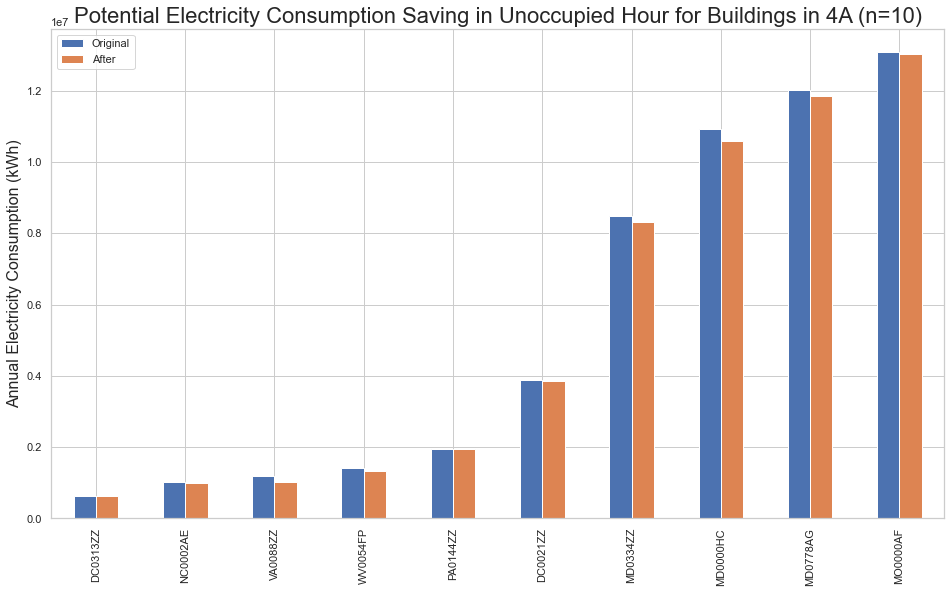

In [155]:
result_un.sort_values(by=['Original']).iloc[:, :-1].set_index('building').plot(kind="bar")
plt.title('Potential Electricity Consumption Saving in Unoccupied Hour for Buildings in 4A (n=10)', fontsize=22)
plt.ylabel('Annual Electricity Consumption (kWh)', fontsize=16)
plt.xlabel('')

## save 3.12% of electricity consumption in unoccupied hours

In [141]:
result_un['Potential Energy Saving'].mean()

3.122

In [144]:
result_un.to_csv('Energy Saving after delay balance point for Unoccupied 4A 19.csv', index=False)

## Concate Occupied and Unoccupied

In [145]:
occ = pd.read_csv('Energy Saving after delay balance point for Occupied 4A 19.csv')
un = pd.read_csv('Energy Saving after delay balance point for Unoccupied 4A 19.csv')

In [146]:
occ

,building,Original,After,Potential Energy Saving
0,DC0011ZZ,7107598.827,6.341569e+06,10.78
1,DC0021ZZ,2991346.396,2.948000e+06,1.45
2,DC0078ZZ,531089.343,4.731524e+05,10.91
3,MD0000HC,8203547.201,8.179244e+06,0.30
4,MO0000AF,8106720.092,8.064607e+06,0.52
5,MO0127ZZ,5406511.512,5.189739e+06,4.01
6,NC0002AE,916052.000,8.814773e+05,3.77
7,PA0000AT,3657204.947,3.631775e+06,0.70
8,PA0144ZZ,2748744.015,2.664123e+06,3.08
9,WV0054FP,1145047.854,1.084148e+06,5.32


In [147]:
un

,building,Original,After,Potential Energy Saving
0,DC0021ZZ,3.880820e+06,3.854593e+06,0.68
1,DC0313ZZ,6.426182e+05,6.415331e+05,0.17
2,MD0000HC,1.093953e+07,1.059330e+07,3.16
3,MD0334ZZ,8.472744e+06,8.327296e+06,1.72
4,MD0778AG,1.203131e+07,1.185914e+07,1.43
5,MO0000AF,1.307495e+07,1.303814e+07,0.28
6,NC0002AE,1.024134e+06,9.942684e+05,2.92
7,PA0144ZZ,1.961956e+06,1.961264e+06,0.04
8,VA0088ZZ,1.200871e+06,1.029204e+06,14.30
9,WV0054FP,1.422334e+06,1.329597e+06,6.52


## Compare Clean and without cleaning

In [156]:
un_ = pd.read_csv('4A 19 unoccupied lean detail without cleaning.csv')
un = pd.read_csv('4A 19 unoccupied lean detail.csv')
occ_ = pd.read_csv('4A 19 occupied lean detail without cleaning.csv')
occ = pd.read_csv('4A 19 occupied lean detail.csv')

In [161]:
df_un = pd.DataFrame()

In [162]:
df_un['building'] = un['building']
df_un['clean'] = un['balancePoint']
df_un['without clean'] = un_['balancePoint']

In [168]:
df_un['diff'] = abs(df_un['clean'] - df_un['without clean'])

In [173]:
df_un['diff'].mean()

1.680657396161795

In [174]:
df_occ = pd.DataFrame()
df_occ['building'] = occ['building']
df_occ['clean'] = occ['balancePoint']
df_occ['without clean'] = occ_['balancePoint']
df_occ['diff'] = abs(df_occ['clean'] - df_occ['without clean'])

In [175]:
df_occ['diff'].mean()

2.892197842564438